## Import Libraries

In [ ]:
!pip install --upgrade huggingface_hub
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
from transformers import pipeline
from datasets import load_dataset, Dataset
from google.colab import drive
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

## Load Dataset

In [ ]:
### START OF CODE FROM EXTERNAL SOURCE (URL: https://huggingface.co/datasets/tweets-hate-speech-detection/tweets_hate_speech_detection)
ds = load_dataset("tweets-hate-speech-detection/tweets_hate_speech_detection")
### END OF CODE FROM EXTERNAL SOURCE (URL: https://huggingface.co/datasets/tweets-hate-speech-detection/tweets_hate_speech_detection)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.58k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31962 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/17197 [00:00<?, ? examples/s]

## EDA

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 17197
    })
})

In [ ]:
ds['train']

Dataset({
    features: ['label', 'tweet'],
    num_rows: 31962
})

In [ ]:
df = pd.DataFrame(ds['train'])

In [ ]:
df

,label,tweet
0,0,@user when a father is dysfunctional and is so...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
...,...,...
31957,0,ate @user isz that youuu?ðððððð...
31958,0,to see nina turner on the airwaves trying to w...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"@user #sikh #temple vandalised in in #calgary,..."


## Undersampling

In [ ]:
min_samples = df['label'].value_counts().min()
print(min_samples)

2242


In [ ]:
balanced_df = df.groupby('label').apply(lambda x: x.sample(min_samples, random_state=97))

<ipython-input-9-c0d05cb3ea43>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('label').apply(lambda x: x.sample(min_samples, random_state=97))


In [ ]:
sampled_df = balanced_df.sample(300, random_state=97)

In [ ]:
print(sampled_df['label'].value_counts())

label
1    154
0    146
Name: count, dtype: int64


In [ ]:
sampled_df = sampled_df.drop(columns=['label'])

In [ ]:
sampled_df

tweet
label                                                         
0     519    it looked easy till my turn  #rap #hiphop #roc...
1     19165  @user no joke! i'm tired of #celebrities actin...
0     14287  relax* relax* relax* #enjoymylife#enjoylife#en...
      21943  some people don't want opinions like they ask ...
1     1346   @user #newyear! new #prez. new #destruction. n...
...                                                        ...
0     3021   shout out to all @user people in @user heading...
1     8604   #goverment #left is against #womensrighttochoo...
0     8970       @user ah what have i missed  who has he got  
1     22635  @user needs to exit the political and journali...
0     11843  no brainer if gordie howe had half a billion t...

[300 rows x 1 columns]

## Download the Sampled data

In [ ]:
drive.mount('/content/drive')
directory='/content/drive/MyDrive/INFO-555_project_2/data'

Mounted at /content/drive


### Skip this part if you are exploring

In [ ]:
### START OF CODE FROM EXTERNAL SOURCE (URL: https://stackoverflow.com/questions/273192/how-do-i-create-a-directory-and-any-missing-parent-directories)
Path(directory).mkdir(parents=True, exist_ok=True)
### START OF CODE FROM EXTERNAL SOURCE (URL: https://stackoverflow.com/questions/273192/how-do-i-create-a-directory-and-any-missing-parent-directories)

In [ ]:
sampled_df.to_csv(directory + '/sampled_df.csv', index=False)

## Load the annotated data

In [ ]:
Kiwoon_df = pd.read_excel(directory + '/annotation_Kiwoon.xlsx')
Noah_df = pd.read_excel(directory + '/annotation_Noah.xlsx')
Kiwoon_df = pd.DataFrame(Kiwoon_df)
Noah_df = pd.DataFrame(Noah_df)

In [ ]:
Kiwoon_df = Kiwoon_df.iloc[:, [0, 1]]
Kiwoon_df = Kiwoon_df.replace({0: 'nothate', 1: 'hate'})
Kiwoon_df.head()

,tweet,label_K
0,it looked easy till my turn #rap #hiphop #roc...,nothate
1,@user no joke! i'm tired of #celebrities actin...,nothate
2,relax* relax* relax* #enjoymylife#enjoylife#en...,nothate
3,some people don't want opinions like they ask ...,nothate
4,@user #newyear! new #prez. new #destruction. n...,nothate


In [ ]:
Noah_df = Noah_df.iloc[:, [0, 1]]
Noah_df = Noah_df.replace({0: 'nothate', 1: 'hate'})
Noah_df.head()

,tweet,label_N
0,it looked easy till my turn #rap #hiphop #roc...,nothate
1,@user no joke! i'm tired of #celebrities actin...,nothate
2,relax* relax* relax* #enjoymylife#enjoylife#en...,nothate
3,some people don't want opinions like they ask ...,nothate
4,@user #newyear! new #prez. new #destruction. n...,hate


In [ ]:
Annotation = pd.DataFrame(sampled_df['tweet']).reset_index(drop=True)
Annotation['label_K'] = Kiwoon_df['label_K']
Annotation['label_N'] = Noah_df['label_N']

In [ ]:
Annotation.head()

,tweet,label_K,label_N
0,it looked easy till my turn #rap #hiphop #roc...,nothate,nothate
1,@user no joke! i'm tired of #celebrities actin...,nothate,nothate
2,relax* relax* relax* #enjoymylife#enjoylife#en...,nothate,nothate
3,some people don't want opinions like they ask ...,nothate,nothate
4,@user #newyear! new #prez. new #destruction. n...,nothate,hate


## Annotation Using an LLM (Prediction)

In [ ]:
 sampled_ds = Dataset.from_pandas(sampled_df)

In [ ]:
### START OF CODE FROM EXTERNAL SOURCE (URL:https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target)
pipe = pipeline("text-classification", model="facebook/roberta-hate-speech-dynabench-r4-target", batch_size=8, device=0)

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [ ]:
HS = pipe(sampled_ds['tweet'], truncation=True)
### END OF CODE FROM EXTERNAL SOURCE (URL:https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target)

In [ ]:
HS_df = pd.DataFrame(HS)
Annotation['label_LLM'] = HS_df['label']
Annotation.head()

,tweet,label_K,label_N,label_LLM
0,it looked easy till my turn #rap #hiphop #roc...,nothate,nothate,nothate
1,@user no joke! i'm tired of #celebrities actin...,nothate,nothate,nothate
2,relax* relax* relax* #enjoymylife#enjoylife#en...,nothate,nothate,nothate
3,some people don't want opinions like they ask ...,nothate,nothate,nothate
4,@user #newyear! new #prez. new #destruction. n...,nothate,hate,nothate


## Summary Statistics

In [ ]:
for label in ['label_K', 'label_N', 'label_LLM']:
    print(f"{label} value counts:")
    print(Annotation[label].value_counts())
    print()

label_K value counts:
label_K
nothate    245
hate        55
Name: count, dtype: int64

label_N value counts:
label_N
nothate    263
hate        37
Name: count, dtype: int64

label_LLM value counts:
label_LLM
nothate    263
hate        37
Name: count, dtype: int64



Text(0.5, 1.0, 'Annotater: LLM')

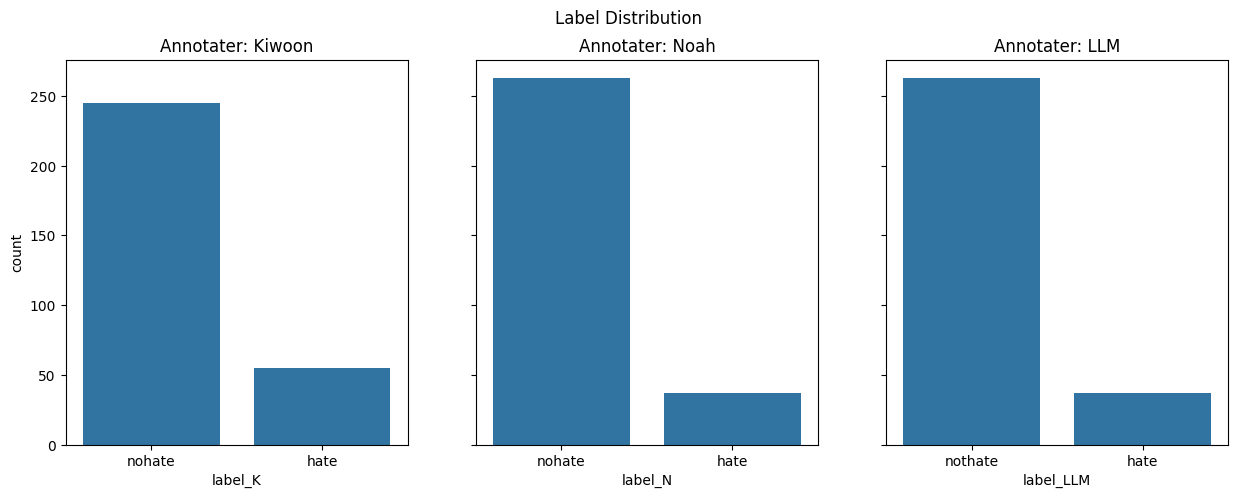

In [ ]:
### START OF CODE FROM EXTERNAL SOURCE (URL:https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Label Distribution')

sns.countplot(ax=axes[0], data=Annotation, x='label_K')
axes[0].set_title('Annotater: Kiwoon')

sns.countplot(ax=axes[1], data=Annotation, x='label_N')
axes[1].set_title('Annotater: Noah')

sns.countplot(ax=axes[2], data=Annotation, x='label_LLM')
axes[2].set_title('Annotater: LLM')
### END OF CODE FROM EXTERNAL SOURCE (URL:https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8)

## IAA

In [ ]:
### START OF CODE FROM EXTERNAL SOURCE (URL:https://scikit-learn.org/dev/modules/generated/sklearn.metrics.cohen_kappa_score.html)
cohen_kappa_score(Annotation['label_K'], Annotation['label_N'])

0.5920101997450065

In [ ]:
cohen_kappa_score(Annotation['label_N'], Annotation['label_LLM'])

0.4450724488747303

In [ ]:
cohen_kappa_score(Annotation['label_K'], Annotation['label_LLM'])
### END OF CODE FROM EXTERNAL SOURCE (URL:https://scikit-learn.org/dev/modules/generated/sklearn.metrics.cohen_kappa_score.html)

0.46451338716532087

## Error Analysis

In [ ]:
KN = Annotation[Annotation['label_N'] != Annotation['label_K']]
KN.iloc[:, [0, 1, 2]]

,tweet,label_K,label_N
4,@user #newyear! new #prez. new #destruction. n...,nothate,hate
20,the white flight of derek black #kkk #trump ...,hate,nothate
26,"content: #abuse, #pedophilia, #stalking, #hara...",hate,nothate
30,#intrumpsamerica extending your hand &amp; uni...,nothate,hate
41,"thanks to racists + fascist it's now 280,- + ...",nothate,hate
49,@user @user needs to fire @user &amp; the dumb...,hate,nothate
56,@user white people got nothing to do with this...,hate,nothate
67,#video #lithuania lisa likes cuckold write no...,hate,nothate
77,"#koreans &amp; joseon people in japan, will ab...",hate,nothate
79,white fragility: why itâs so hard to talk to...,hate,nothate


In [ ]:
LK = Annotation[Annotation['label_LLM'] != Annotation['label_K']]
LK.iloc[:, [0, 1, 3]]

,tweet,label_K,label_LLM
16,"#joemixon #espn #minnesotavikings, and it ""goe...",hate,nothate
18,@user @user so now roseanne is walking back he...,hate,nothate
19,@user #libtard #regressive=. can't effo a logi...,hate,nothate
20,the white flight of derek black #kkk #trump ...,hate,nothate
26,"content: #abuse, #pedophilia, #stalking, #hara...",hate,nothate
31,"#carriefisher was a #feminist, fighting &amp;...",nothate,hate
67,#video #lithuania lisa likes cuckold write no...,hate,nothate
77,"#koreans &amp; joseon people in japan, will ab...",hate,nothate
79,white fragility: why itâs so hard to talk to...,hate,nothate
80,irritations like new-#ghostbusters haters indi...,hate,nothate


In [ ]:
NL = Annotation[Annotation['label_N'] != Annotation['label_LLM']]
NL.iloc[:, [0, 2, 3]]

,tweet,label_N,label_LLM
4,@user #newyear! new #prez. new #destruction. n...,hate,nothate
16,"#joemixon #espn #minnesotavikings, and it ""goe...",hate,nothate
18,@user @user so now roseanne is walking back he...,hate,nothate
19,@user #libtard #regressive=. can't effo a logi...,hate,nothate
30,#intrumpsamerica extending your hand &amp; uni...,hate,nothate
31,"#carriefisher was a #feminist, fighting &amp;...",nothate,hate
41,"thanks to racists + fascist it's now 280,- + ...",hate,nothate
49,@user @user needs to fire @user &amp; the dumb...,nothate,hate
56,@user white people got nothing to do with this...,nothate,hate
88,@user @user have the balls to it and expose m...,nothate,hate


In [ ]:
KN.info()
LK.info()
NL.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 4 to 298
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      32 non-null     object
 1   label_K    32 non-null     object
 2   label_N    32 non-null     object
 3   label_LLM  32 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 16 to 296
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      42 non-null     object
 1   label_K    42 non-null     object
 2   label_N    42 non-null     object
 3   label_LLM  42 non-null     object
dtypes: object(4)
memory usage: 1.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 36 entries, 4 to 298
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      36 non-null     object
 1   label_K    36 non-null     object
 

## Data Quality Demonstration - Logistic Regression

### Logistic Regression - Process data

In [ ]:
traintexts = Annotation['tweet']
trainlabels_K = Annotation['label_K']
trainlabels_N = Annotation['label_N']
trainlabels_LLM = Annotation['label_LLM']

In [ ]:
### START OF CODE FROM EXTERNAL SOURCE (URL:https://pandas.pydata.org/docs/reference/api/pandas.Index.isin.html)
remaining_df = balanced_df.loc[~balanced_df.index.isin(sampled_df.index)]
### END OF CODE FROM EXTERNAL SOURCE (URL:https://pandas.pydata.org/docs/reference/api/pandas.Index.isin.html)
test = remaining_df.sample(100, random_state=97)
test = test.replace({0: 'nothate', 1: 'hate'})

In [ ]:
testtexts = test['tweet']
testlabels = test['label']

### Logistic Regression - Define a Model

In [ ]:
### From here, I used my own code from previous class term project(Ling-539) for building Logistic Regression Baseline Model
### (URL:https://github.com/uazhlt-ms-program/ling-539-spring-2024-class-competition-KiwoonHong/blob/main/scripts/Logistic%20Classifier.ipynb)

In [ ]:
class TextToFeatures:
    def __init__(self):
        self.vectorizer = CountVectorizer(decode_error='ignore')

    def transform(self, texts):
        return self.vectorizer.transform(texts)

    def fit_transform(self, texts):
        return self.vectorizer.fit_transform(texts)

In [ ]:
class Classifier:
    def __init__(self):
        self.model = LogisticRegression()

    def fit(self, features, labels):
        self.model.fit(features, labels)

    def predict(self, features):
        return self.model.predict(features)

### Logistic Regression - Prediction and evaluation

In [ ]:
ttf = TextToFeatures()
features = ttf.fit_transform(traintexts)

classifier = Classifier()
classifier.fit(features, trainlabels_N)
classifier2 = Classifier()
classifier2.fit(features, trainlabels_K)

test_features = ttf.transform(testtexts)
predictions = classifier.predict(test_features)
predictions2 = classifier2.predict(test_features)

In [ ]:
matrix = confusion_matrix(testlabels, predictions)
matrix2 = confusion_matrix(testlabels, predictions2)
print(matrix,'\n\n',matrix2)


[[ 4 46]
 [ 0 50]] 

 [[ 5 45]
 [ 0 50]]


In [ ]:
print(predictions, '\n\n', predictions2)

['nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'hate' 'nothate' 'nothate' 'hate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'hate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'hate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate' 'nothate'
 'nothat